# Model training

This script performs the model training of the Coco dataset.

It loads the data from the sources, build the model network, train it.

In [17]:
import os
import json
from collections import defaultdict # a dict that returns empty if key is not found
import random
import pandas as pd
import numpy as np

import torch

from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from PIL import Image

In [5]:
# define the cocoParser() class with methods. Use to load and retreive data
class COCOParser:

    def __init__(self, anns_file, images_dir):
        """
        Initialize the object by loading and extracting the labels, and loading the location of the images
        """
        with open(anns_file, 'r') as f: # reads the annotation JSON file using json library and stored in the coco variable
            coco = json.load(f)
        
        self.images_dir = images_dir
        self.images_dict = {} # a dictionary that links an image id to the corresponding image information
        self.categories_dict = {} # a dictionary that links the category id to its category information
        self.annotations_dict = defaultdict(list) # a dictionary that links the annotation image_id to the corresponding annotation information
        self.image_info_dict = {} # a dictionary that links a filename to all the relevant info (height, width, segmentation, bbox, category_name)

        for image in coco['images']:
            self.images_dict[image['id']] = image
        for category in coco['categories']:
            self.categories_dict[category['id']] = category
        for annotation in coco['annotations']:
            annotation.update(self.categories_dict[annotation['category_id']])
            self.annotations_dict[annotation['image_id']].append(annotation)
        for image in coco['images']:
            self.image_info_dict[image['file_name']] = image
            self.image_info_dict[image['file_name']]['instances'] = self.annotations_dict[self.image_info_dict[image['file_name']]['id']]

        
    
    def get_infoIds(self, file_names):
        """
        takes file_names, which is a list of image file names, as an input parameter and returns all the info related.
        """
        return [self.image_info_dict[file_name] for file_name in file_names]
    
    def get_infoId(self, file_name):
        """
        takes file_name, which is a string containing image file name, as an input parameter and returns all the info related.
        """
        return self.image_info_dict[file_name]
    
    def plot_images_with_annotations(self, file_name):
        # Retrieve the image information and annotations
        image_info = self.get_infoId(file_name)
        image_path = os.path.join(self.images_dir, file_name)
        
        # Open the original image
        image = Image.open(image_path)
        
        # Create subplots for the original image, image with bounding boxes, and image with masks
        fig, axes = plt.subplots(1, 3, figsize=(20, 8))
        
        # 1. Plot the original image
        axes[0].imshow(image)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        # 2. Plot the image with bounding boxes
        axes[1].imshow(image)
        axes[1].set_title("Image with Bounding Boxes")
        axes[1].axis('off')
        for instance in image_info['instances']:
            bbox = instance['bbox']  # COCO format: [x, y, width, height]
            category_name = instance['name']
            rect = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=2, edgecolor='r', facecolor='none')
            axes[1].add_patch(rect)
            axes[1].text(bbox[0], bbox[1] - 5, category_name, color='red', fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
        
        # 3. Plot the image with masks
        axes[2].imshow(image)
        axes[2].set_title("Image with Masks")
        axes[2].axis('off')
        for instance in image_info['instances']:
            segmentation = instance['segmentation']
            color = np.random.rand(3,)  # Random color for each mask
            if isinstance(segmentation, list):  # Handle polygons
                for poly in segmentation:
                    poly_np = np.array(poly).reshape((-1, 2))
                    axes[2].fill(poly_np[:, 0], poly_np[:, 1], color=color, alpha=0.5)
        
        plt.tight_layout()
        plt.show()

Setting the data locations

In [8]:
coco_annotations_instances_train_file="/home/maver02/Development/Datasets/COCO/annotations/instances_train2017.json"
coco_annotations_instances_val_file="/home/maver02/Development/Datasets/COCO/annotations/instances_val2017.json"
coco_images_train_dir="/home/maver02/Development/Datasets/COCO/train2017"
coco_images_val_dir="/home/maver02/Development/Datasets/COCO/val2017"

Loading data

In [9]:
coco_parser = COCOParser(coco_annotations_instances_train_file, coco_images_train_dir)

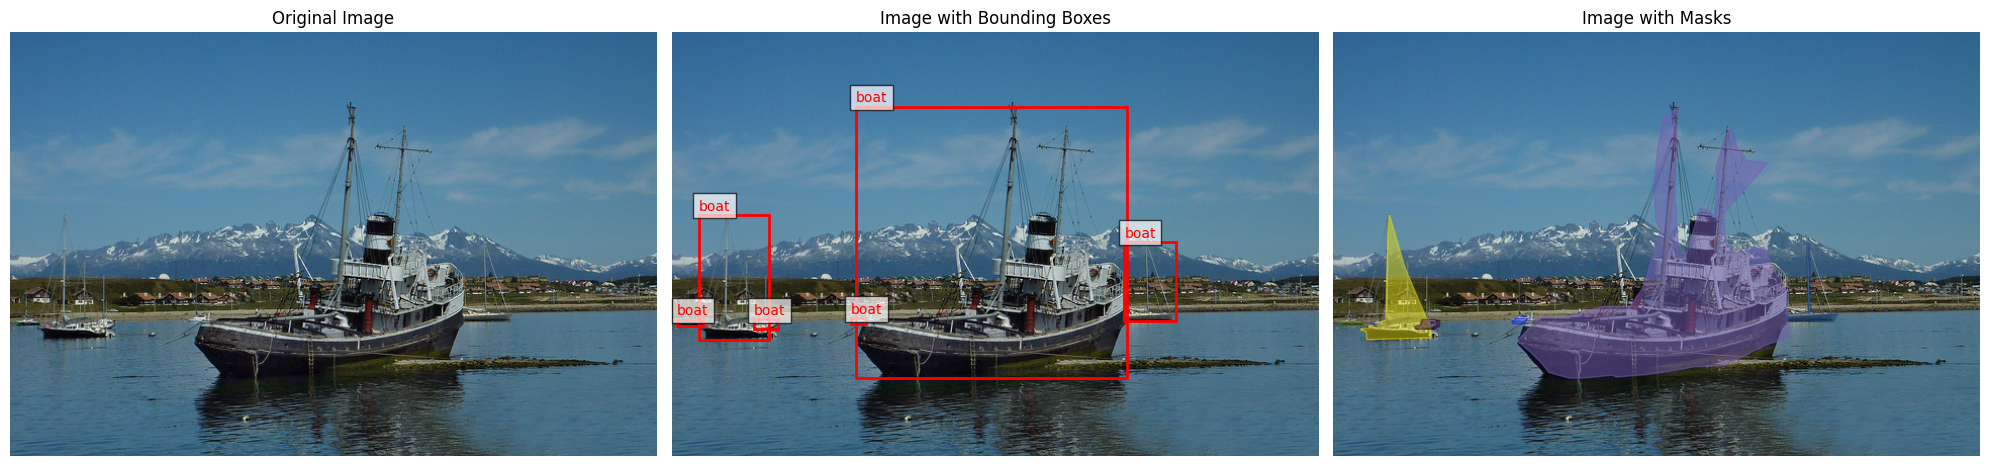

In [24]:
# Example usage
file_name = random.choice(os.listdir(coco_images_train_dir))  # Replace with an image file name from your dataset
coco_parser.plot_images_with_annotations(file_name)

In [39]:
image_info = coco_parser.get_infoId(file_name)
print(image_info)
image_path = os.path.join(coco_parser.images_dir, file_name)
print(image_path)

{'license': 4, 'file_name': '000000451036.jpg', 'coco_url': 'http://images.cocodataset.org/train2017/000000451036.jpg', 'height': 420, 'width': 640, 'date_captured': '2013-11-18 03:02:36', 'flickr_url': 'http://farm6.staticflickr.com/5091/5412452795_7c6787cc19_z.jpg', 'id': 451036, 'instances': [{'segmentation': [[96.15, 302.68, 76.92, 303.15, 32.44, 304.45, 32.32, 297.25, 29.96, 295.36, 26.42, 295.01, 26.78, 293.36, 34.92, 293.59, 34.44, 290.76, 37.39, 290.53, 37.98, 290.41, 39.4, 292.06, 43.17, 292.53, 45.42, 287.11, 48.25, 286.28, 51.31, 284.75, 51.79, 268.94, 52.61, 236.85, 53.56, 201.45, 54.85, 180.93, 55.92, 183.76, 60.16, 198.27, 70.43, 233.19, 96.03, 293.24, 95.79, 302.44]], 'area': 3091.072449999999, 'iscrowd': 0, 'image_id': 451036, 'bbox': [26.42, 180.93, 69.73, 123.52], 'category_id': 9, 'id': 9, 'supercategory': 'vehicle', 'name': 'boat'}, {'segmentation': [[275.27, 339.59, 246.89, 342.43, 232.7, 342.43, 212.84, 336.76, 205.27, 327.3, 194.86, 316.89, 181.62, 305.54, 203.38